<a href="https://colab.research.google.com/github/ssubbinn/ESAA/blob/main/hospital_YB_2%EC%A1%B0_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **병원 개/폐업 분류 예측 경진대회**
​
https://dacon.io/competitions/official/9565/data  
- 과제 : 데이콘의 '병원 개/폐업 분류 예측 경진대회' 데이터셋을 전처리 및 시각화하고, 분류 알고리즘을 적용한다.
- 조건 : 분류 모델 3가지 이상 적용

## **데이터 불러오기, library import**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifierBase
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/YB_2조/미니프로젝트/2. hospital/train.csv')
test = pd.read_csv('/content/drive/MyDrive/YB_2조/미니프로젝트/2. hospital/test.csv')

## **Research**

### **1. 기존 변수**

**1) bedCount (병상 수)**
- 병상 수가 늘어날수록 병원 생존 가능성 감소
- 병상 수에 따라 의원, 병원, 종합병원, 상급종합병원으로 분류

**2) sido (병원 지역)**
- 전남 지역의 인구감소 현상이 뚜렷하고 지역 환자들의 수도권 대형병원 쏠림 현상 등이 갈수록 심화
- 전라권의 병원 폐업률이 다른 권역에 비해 높음 (평균: 5.8%, 전라권: 8.8%)

**3) revenue (매출액)**
- 일정 기간 기업 규모 혹은 영업 성과가 얼마나 증가했는지, 병원의 **성장성**에 대한 지표

**4) profit (당기순이익)**
- 매출에서 비용을 모두 제거했을 때 이익이 얼마나 남는지, 병원의 **수익성**에 대한 지표

### **2. 새로운 변수**

**1) business_year (개업 시기)**
- 개업 후 1~31개월 간 병원 생존률은 크게 감소

**2) employee_diff (직원 수 차이)**
- 의료인이 1명 늘면 병원이 폐업할 확률 7.34%씩 감소

**3) op_profit (영업이익)**
- 일정 기간 기업 규모 혹은 영업 성과가 얼마나 증가했는지, 병원의 **성장성**에 대한 지표

**4) liquidRatio (유동비율)**
- 부채를 상환할 수 있는 능력이 얼마나 되는지, 병원의 **안정성**에 대한 지표 
- 유동비율이 낮으면 **안정성**이 떨어짐

**5) inventory_turnover (재고자산회전율)**
- 동일한 자원으로 더 높은 수익을 낼 수 있는지, 병원의 **효율성(활동성)**에 대한 지표


## **EDA**

### **1. 불필요한 칼럼 제거**
병원 고유 번호(inst_id)와 병원 시군구 자료 (sgg) 변수 제거

In [ ]:
train.drop(['inst_id','sgg'], axis = 1, inplace = True)
test.drop(['inst_id','sgg'], axis = 1, inplace = True)

### **2. 결측치 대체**

**1) 부채총액 (debt)** <br/>
부채총계 (debt) = 유동부채 (liquidLiabilites) + 비유동부채 (NCLiabilities)

In [ ]:
train.debt1.value_counts()
#0값이 너무 많음->부정확한 데이터일 가능성이 매우 높음

0.000000e+00    31
1.006269e+09     2
2.803885e+09     2
9.528087e+07     2
4.307441e+10     2
                ..
8.677467e+09     1
3.811639e+09     1
1.623970e+10     1
2.670679e+09     1
5.418547e+09     1
Name: debt1, Length: 257, dtype: int64

In [ ]:
# debt1 결측치(0인값) 대체
train['debt1'] = train['liquidLiabilities1'] + train['NCLiabilities1']
train['debt2'] = train['liquidLiabilities2'] + train['NCLiabilities2']

test['debt1'] = test['liquidLiabilities1'] + test['NCLiabilities1']
test['debt2'] = test['liquidLiabilities2'] + test['NCLiabilities2']

**2) 순자산 (netAsset)** <br/>
순자산 (netAsset) = 유동자산 (liquidAsset) + 비유동자산 (nonCAsset) - 부채총액 (debt)

In [ ]:
train.netAsset1.value_counts()
# netAsset 역시 0값이 너무 많음->부정확한 데이터일 가능성이 매우 높음

 0.000000e+00    31
 2.267631e+10     2
 1.499370e+09     2
 2.009490e+09     2
 8.366773e+08     2
                 ..
-1.235651e+08     1
 1.805357e+09     1
 9.517877e+09     1
 1.186884e+09     1
 5.490668e+09     1
Name: netAsset1, Length: 257, dtype: int64

In [ ]:
# netAsset 결측치(0인값) 대체
train['netAsset1'] = train['liquidAsset1'] + train['nonCAsset1'] - train['debt1']
train['netAsset2'] = train['liquidAsset2'] + train['nonCAsset2'] - train['debt2']

test['netAsset1'] = test['liquidAsset1'] + test['nonCAsset1'] - test['debt1']
test['netAsset2'] = test['liquidAsset2'] + test['nonCAsset2'] - test['debt2']

**3) 고용한 총 직원의 수 (employee)** <br/>
쉼표 제거 및 float 형 변환

In [ ]:
test["employee1"] = test["employee1"].str.replace(",","").astype("float")
test["employee2"] = test["employee2"].str.replace(",","").astype("float")

**4) 범주형 변수 nan** <br/>
범주형인 instkind, ownerChange의 nan은 **최빈값**으로 대체

In [ ]:
values = {'instkind':"nursing_hospital", 'ownerChange':"same"}
train.fillna(value = values, inplace = True)
test.fillna(value = values, inplace = True)

**5) 수치형 변수 na**
수치형의 na는 **중간값**으로 대체
- 평균값으로 대체했을 때, 극단값에 영향 받는 상황을 방지하고자 함

In [ ]:
train = train.fillna(train.median())
test = test.fillna(test.median())

## **New variables**

**op_profit (영업이익)** <br/>
영업이익 = 매출액 - 매출원가 - 영업비용 (판매비와 관리비)
- op_profit1 = revenue1 - salescost1 - sga1
- op_profit2 = revenue2 - salescost2 - sga2


In [ ]:
# train에 변수 추가
train['op_profit1'] = train.revenue1 - train.salescost1 - train.sga1
train['op_profit2'] = train.revenue2 - train.salescost2 - train.sga2

# test에 변수 추가
test['op_profit1'] = test.revenue1 - test.salescost1 - test.sga1
test['op_profit2'] = test.revenue2 - test.salescost2 - test.sga2

**business_year(개업 시기))**
- business_year = 2017 - open_year
- open_year: openDate에서 'year' 추출

In [ ]:
# 데이터 타입을 datetime으로 변환하고 년/월만 남김
train["openDate"].isnull().sum(),test["openDate"].isnull().sum()
test["openDate"] = test["openDate"].fillna(0)

train["openDate"] = pd.to_datetime(train["openDate"].astype("str"), format = "%Y/%m/%d")
test["openDate"] = pd.to_datetime(test["openDate"].astype("int").astype("str"), format = "%Y/%m/%d", errors = "coerce")

In [ ]:
train["open_year"] = train["openDate"].dt.year
test["open_year"] = test["openDate"].dt.year

train.drop(columns = "openDate", axis = 1, inplace = True)
test.drop(columns = "openDate", axis = 1, inplace = True)

In [ ]:
train["business_year"] = 2017 - train["open_year"]
test["business_year"] = 2017 - test["open_year"]

**employee_diff (직원 수 차이)** <br/>
2017년과 2016년의 직원 수 비교
- employee_diff = employee1 - employee2

In [ ]:
train["employee_diff"] = train["employee1"] - train["employee2"]
test["employee_diff"] = test["employee1"] - test["employee2"]

**sido(병원의 광역 지역 정보)**

In [ ]:
# ~남 ~북을 제거, ex. 충남 -> 충 / 충북 -> 충
train["sido"] = train["sido"].str.replace("nam|buk", "")
test["sido"] = test["sido"].str.replace("nam|buk", "")

# 인천과 경기를 묶어줌
train["sido"] = train["sido"].str.replace("gyeonggi|incheon", "gyeon-in")
test["sido"] = test["sido"].str.replace("gyeonggi|incheon", "gyeon-in")

In [ ]:
# 한글명으로 변환
train["sido"] = train["sido"].replace({"busan": "부산",
                                        "choong": "충청도",
                                        "daegu": "대구",
                                        "daejeon": "대전",
                                        "gangwon": "강원도",
                                        "gwangju": "광주",
                                        "gyeon-in": "경인",
                                        "gyeong": "경상도",
                                        "jeju": "제주도",
                                        "jeon": "전라도",
                                        "sejong": "세종",
                                        "seoul": "서울",
                                        "ulsan": "울산"})
test["sido"] = test["sido"].replace({"busan": "부산",
                                        "choong": "충청도",
                                        "daegu": "대구",
                                        "daejeon": "대전",
                                        "gangwon": "강원도",
                                        "gwangju": "광주",
                                        "gyeon-in": "경인",
                                        "gyeong": "경상도",
                                        "jeju": "제주도",
                                        "jeon": "전라도",
                                        "sejong": "세종",
                                        "seoul": "서울",
                                        "ulsan": "울산"})

**bedCount (병상의 수)** <br/>
병상의 수에 따라 의원, 병원, 종합병원, 상급종합병원으로 분류
- 상급종합병원 : 입원환자 500명 이상 수용 가능
- 종합병원 : 입원환자 100명 이상 500명 미만 수용 가능
- 병원 : 입원 환자 30명 이상 100명 미만 수용 가능
- 의원 : 입원 환자 30명 이하 수용 가능

In [ ]:
def bedCount2band(num):
    if num < 30: return "의원"
    elif 30 <= num < 100: return "병원"
    elif 100 <= num < 500: return "종합병원"
    elif num >= 500: return "상급종합병원"

In [ ]:
train["bedCount"] = train["bedCount"].apply(bedCount2band)
test["bedCount"] = test["bedCount"].apply(bedCount2band)

## **Scaling**

- train, test 데이터의 histogram을 살펴보면 데이터가 왼쪽으로 치우친것을 확인할 수 있음 -> **로그 변환**을 통해 데이터를 중앙으로 모으는 작업이 필요하다고 판단

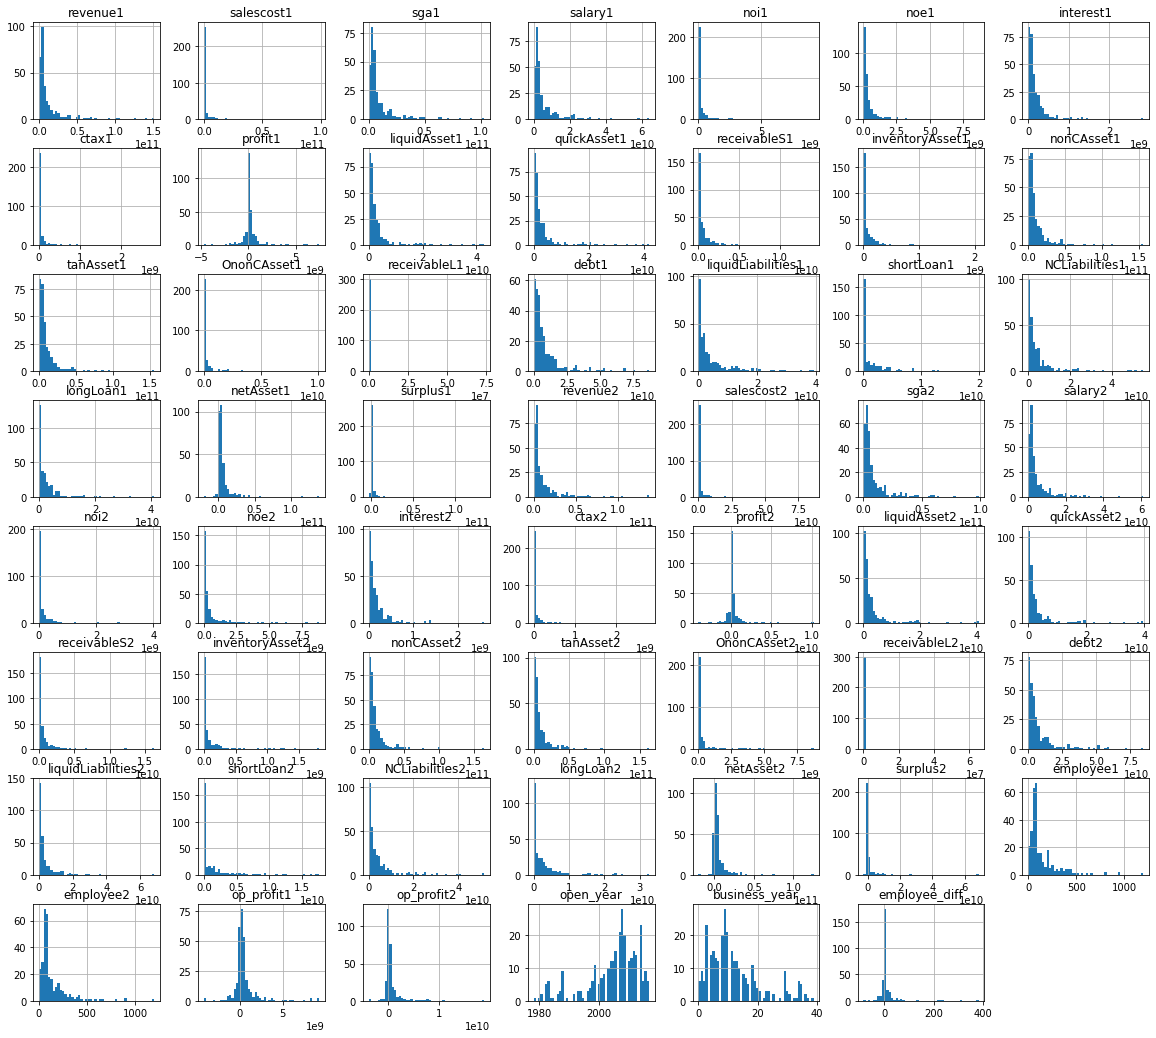

In [ ]:
train_hist= train.hist(bins=50, figsize=(20, 18))

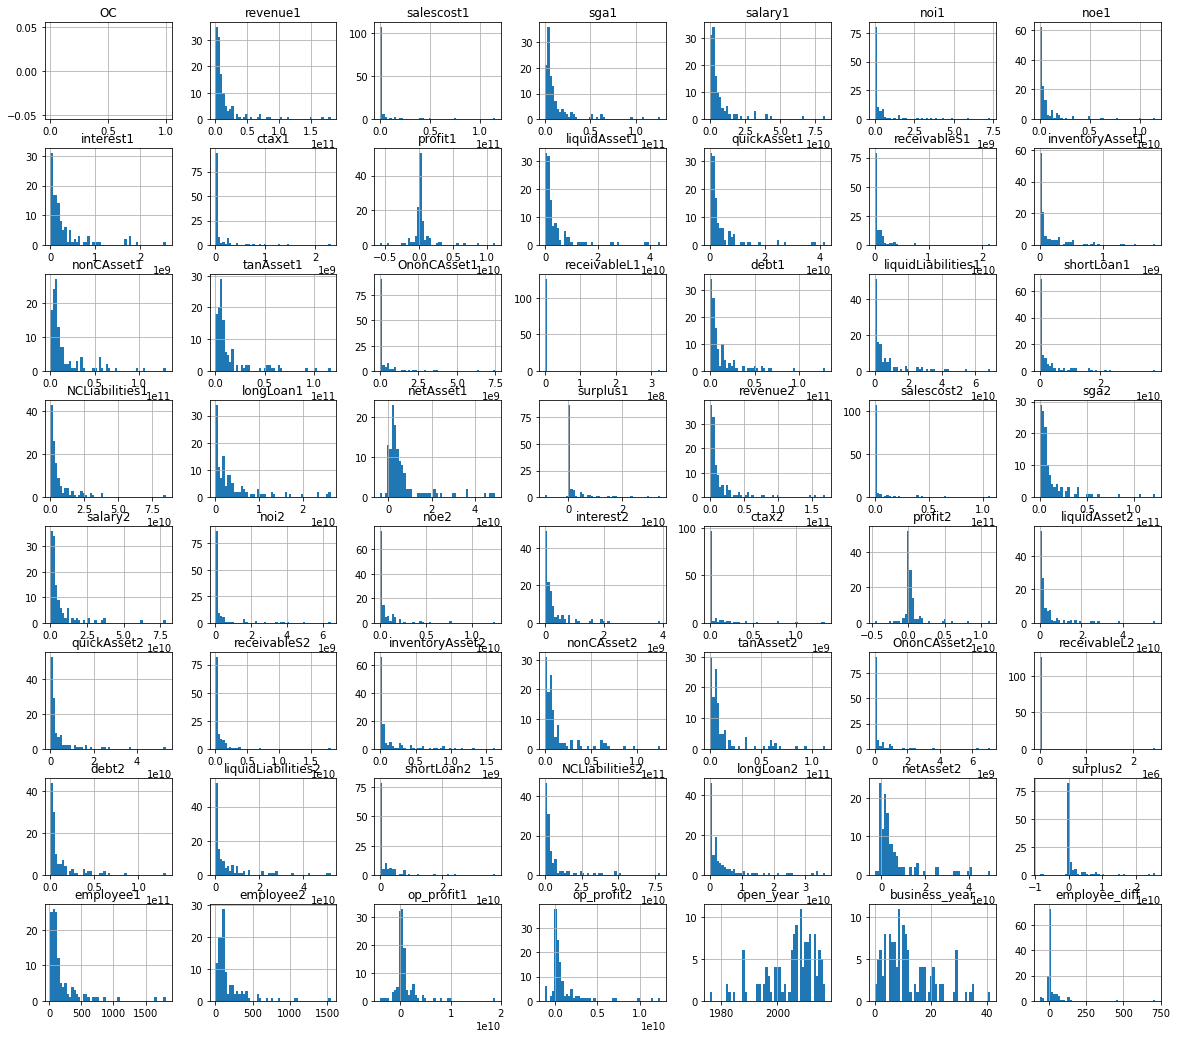

In [ ]:
test_hist= test.hist(bins=50, figsize=(20, 18))

### **1. 양수화**

In [ ]:
# Train/Test 데이터의 수치형 변수들에 대해 scaling 진행
train_col = train.drop(['OC','sido','ownerChange','instkind','bedCount'], axis = 1)
test_col = test.drop(['OC','sido','ownerChange','instkind','bedCount'], axis = 1)

In [ ]:
# 로그 변환 이전, Train 데이터 칼럼의 음수 값을 제거하기 위한 과정
for i in train_col.columns:
  train_col[i] -= min(train_col[i])

In [ ]:
# 로그 변환 이전, Test 데이터 칼럼의 음수 값을 제거하기 위한 과정
for i in test_col.columns:
  test_col[i] -= min(test_col[i])

### **2. log scaling**

In [ ]:
train_scaled_log=np.log1p(train_col)

In [ ]:
test_scaled_log=np.log1p(test_col)

## **Encoding**

**sido**

In [ ]:
train['sido'].value_counts().index

Index(['경상도', '경인', '전라도', '충청도', '부산', '서울', '대구', '대전', '강원도', '울산', '광주',
       '세종'],
      dtype='object')

In [ ]:
test['sido'].value_counts().index

Index(['경상도', '경인', '전라도', '부산', '충청도', '서울', '울산', '제주도', '대구', '대전', '세종'], dtype='object')

In [ ]:
#labelencoding을 진행할 시 test에는 존재하지만 train에는 존재하지 않는 '제주도'칼럼을 처리하는 방법을 찾지못함
#따라서 손수 encoding 진행
train['sido'].replace({'경상도':6,'경인':5,
                           '전라도':4,'충청도':4,'부산':3,
                          '서울':3,'대구':3,
                          '전라도':2, '대전':2,'광주':2,'강원도':1,
                          '울산':1,'세종':0,'제주도':0},inplace = True)
test['sido'].replace({'경상도':6,'경인':5,
                           '전라도':4,'충청도':4,'부산':3,
                          '서울':3,'대구':3,
                          '전라도':2, '대전':2,'광주':2,'강원도':1,
                          '울산':1,'세종':0,'제주도':0},inplace = True)

**OC**

In [ ]:
#close를 0으로, open을 1로 바꿔줌
train['OC'].replace({' close':0,'open':1},inplace = True)

In [ ]:
train['OC'].value_counts()

1    286
0     15
Name: OC, dtype: int64

**bedcount**
-bedCount 변수에 대해서는 labelencoding 진행

In [ ]:
encoder=LabelEncoder()
encoder.fit(train.bedCount)
train.bedCount=encoder.transform(train.bedCount)
test.bedCount=encoder.transform(test.bedCount)

**instkind & ownerchange**

-instkind, ownerchange 변수에 대해선 one-hot encoding 진행

In [ ]:
train = pd.get_dummies(train, columns = ['instkind','ownerChange'], drop_first = True)
test = pd.get_dummies(test, columns = ['instkind','ownerChange'], drop_first = True)

In [ ]:
train.head()

,OC,sido,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,...,open_year,business_year,employee_diff,instkind_dental_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital,ownerChange_same
0,1,4,3,4.217530e+09,0.0,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,...,2007,10,-2.0,0,0,0,1,0,0,1
1,1,6,3,5.524218e+09,210410492.0,4.684074e+09,2.659892e+09,43637641.0,1.831965e+08,1.097329e+08,...,1997,20,-12.0,0,1,0,0,0,0,1
2,1,5,3,1.004522e+09,515483669.0,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,...,2016,1,233.0,0,0,0,1,0,0,1
3,1,5,3,7.250734e+10,0.0,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,...,2000,17,0.0,0,1,0,0,0,0,1
4,1,6,3,4.904354e+10,0.0,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,...,2005,12,9.0,0,1,0,0,0,0,1


In [ ]:
#test 데이터에서 "OC" 열 삭제
test = test.drop("OC", axis = 1)

In [ ]:
test.head()

,sido,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,...,op_profit2,open_year,business_year,employee_diff,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital,ownerChange_same
0,5,3,6.682486e+10,0.000000e+00,6.565709e+10,3.223695e+10,4.314093e+09,4.901517e+09,1.775872e+09,76680000.0,...,9.924902e+08,1998.0,19.0,0.0,1,0,0,0,0,1
1,0,0,3.495758e+10,0.000000e+00,3.259270e+10,1.672254e+10,6.871024e+07,1.981033e+09,1.936455e+09,0.0,...,-1.142702e+09,2016.0,1.0,8.0,0,1,0,0,0,1
2,2,3,2.326031e+10,2.542571e+09,2.308749e+10,1.168734e+10,1.601943e+09,1.380941e+09,8.101204e+08,0.0,...,-5.592507e+08,1989.0,28.0,7.0,1,0,0,0,0,1
3,3,3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.850652e+09,2.060989e+09,0.000000e+00,0.0,...,0.000000e+00,2010.0,7.0,0.0,1,0,0,0,0,1
4,2,3,5.037025e+10,0.000000e+00,4.855803e+10,2.296346e+10,1.534452e+09,0.000000e+00,2.573804e+09,0.0,...,2.811857e+09,2004.0,13.0,52.0,1,0,0,0,0,1


In [ ]:
#로그변환한 데이터를 기존 데이터에 적용해주기
train_scaled_log[['OC','sido','bedCount']] = train[['OC','sido','bedCount']]
train_scaled_log['ownerChange_same'] = train['ownerChange_same']
train_scaled_log[['instkind_dental_clinic','instkind_general_hospital','instkind_hospital','instkind_nursing_hospital','instkind_traditional_clinic','instkind_traditional_hospital']]=train[['instkind_dental_clinic','instkind_general_hospital','instkind_hospital','instkind_nursing_hospital','instkind_traditional_clinic','instkind_traditional_hospital']]

test_scaled_log[['OC','sido','bedCount']] = train[['OC','sido','bedCount']]
test_scaled_log['ownerChange_same'] = train['ownerChange_same']
test_scaled_log[['instkind_general_hospital','instkind_hospital','instkind_nursing_hospital','instkind_traditional_clinic','instkind_traditional_hospital']]=test[['instkind_general_hospital','instkind_hospital','instkind_nursing_hospital','instkind_traditional_clinic','instkind_traditional_hospital']]

#최종 데이터
train_final = train_scaled_log
test_final = test_scaled_log

#데이터 확인해본 결과 open_year, business_year에서 na 값 발견
test_final.open_year.isna().sum()  #1
test_final.business_year.isna().sum() #1

# na값 중앙값으로 바꾸기
# 최종 데이터 확정
train_final = train_final.fillna(train.median())
test_final = test_final.fillna(test.median())

## **Modeling**

In [ ]:
#변수 할당
X = train_final.drop('OC', axis = 1)
y = train_final.OC

#train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 

#데이터세트 분포 비율 확인
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(240, 64), 테스트 세트 Shape:(61, 64)
학습 세트 레이블 값 분포 비율
1    0.954167
0    0.045833
Name: OC, dtype: float64

 테스트 세트 레이블 값 분포 비율
1    0.934426
0    0.065574
Name: OC, dtype: float64


In [ ]:
# 성능평가지표를 출력해주는 함수 정의
def get_clf_eval(y_test, pred = None, pred_proba = None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
  F1 : {3:.4f}'.format(accuracy, precision, recall, f1))

### **1. xgboost**

In [ ]:
# SMOTE오버 샘플링 적용
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (240, 64) (240,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (458, 64) (458,)
SMOTE 적용 후 레이블 값 분포: 
 1    229
0    229
Name: OC, dtype: int64


In [ ]:
# xgb모델학습 및 성능확인
xgb_clf = XGBClassifier(n_estimators = 1000, random_state = 156, learning_rate = 0.01, max_depth = 7, min_child_weight = 1, colsample_bytree = 0.75, reg_alpha = 0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train_over, y_train_over, early_stopping_rounds = 200,eval_metric='auc',eval_set = [(X_train,y_train),(X_test,y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average = 'macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.986106	validation_1-auc:0.657895
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.996229	validation_1-auc:0.576754
[2]	validation_0-auc:1	validation_1-auc:0.629386
[3]	validation_0-auc:0.998809	validation_1-auc:0.605263
[4]	validation_0-auc:0.998412	validation_1-auc:0.631579
[5]	validation_0-auc:0.999206	validation_1-auc:0.622807
[6]	validation_0-auc:0.999603	validation_1-auc:0.635965
[7]	validation_0-auc:1	validation_1-auc:0.631579
[8]	validation_0-auc:1	validation_1-auc:0.627193
[9]	validation_0-auc:1	validation_1-auc:0.609649
[10]	validation_0-auc:1	validation_1-auc:0.614035
[11]	validation_0-auc:1	validation_1-auc:0.605263
[12]	validation_0-auc:1	validation_1-auc:0.600877
[13]	validation_0-auc:1	validation_1-auc:0.600877
[14]	validation_0-auc:1	validation_1-auc:0.605263
[15]	validation_0-auc:1	validation_1-auc:0.609649
[16]	valid

In [ ]:
get_clf_eval(y_test, pred=xgb_clf.predict(X_test))

오차 행렬
[[ 1  3]
 [ 6 51]]
정확도 : 0.8525, 정밀도 : 0.9444, 재현율 : 0.8947,   F1 : 0.9189


### **2. RandomForest**

In [ ]:
# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(test_final)

In [ ]:
# over 추가

params = {
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행 (n_jobs = -1: 모든 CPU 코어를 이용해 학습)
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))


최적 하이퍼 파라미터:
 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9542


In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators = 300, max_depth = 10, min_samples_leaf = 8, \
                                min_samples_split = 8, random_state = 0)
rf_clf1.fit(X_train_over, y_train_over)
pred = rf_clf1.predict(test_final)

In [ ]:
get_clf_eval(y_test, pred=rf_clf1.predict(X_test))

오차 행렬
[[ 0  4]
 [ 1 56]]
정확도 : 0.9180, 정밀도 : 0.9333, 재현율 : 0.9825,   F1 : 0.9573


**Feature Importance Plot**

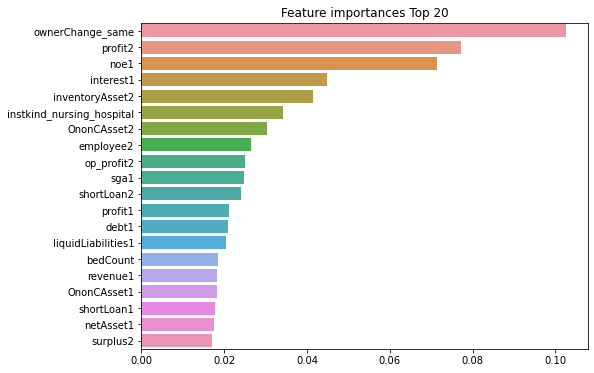

In [ ]:
ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8,6))
plt.title('Feature importances Top 20')
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()


### **3. GBM**

In [ ]:
# GBM 수행 시간 측정을 위함 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train_over, y_train_over)
gb_pred = gb_clf.predict(test_final)
print('GBM 수행 시간: {0:.1f}초'.format(time.time() - start_time))

GBM 수행 시간: 0.6초


In [ ]:
params = {
    'n_estimators':[100,500],
    'learning_rate':[0.05,0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid = params, cv = 2, verbose = 1)
grid_cv.fit(X_train_over, y_train_over)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 500}
최고 예측 정확도: 0.9869


In [ ]:
get_clf_eval(y_test, pred=grid_cv.predict(X_test))

오차 행렬
[[ 0  4]
 [ 1 56]]
정확도 : 0.9180, 정밀도 : 0.9333, 재현율 : 0.9825,   F1 : 0.9573


### 결론

In [ ]:
# 랜덤포레스트 GridSearchCV를 이용해 최적으로 학습된 estimator로 예측 수행
rf_pred =rf_clf1.predict(test_final)

In [ ]:
gd_pred=grid_cv.predict(test_final)

In [ ]:
smpl_sub = pd.read_csv('/content/drive/MyDrive/YB_2조/미니프로젝트/2. hospital/submission_sample.csv')
smpl_sub['OC'] = rf_pred
smpl_sub.head()

smpl_sub.to_csv('/content/drive/MyDrive/YB_2조/미니프로젝트/2. hospital/submission3.csv', index = False)